In [12]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [1]:
# Load data
import pandas as pd
from sklearn.model_selection import train_test_split

df_train = pd.read_csv("../data/processed/train_selected.csv")
df_test = pd.read_csv("../data/processed/test_selected.csv")

X_train = df_train.drop(columns=['target'])
y_train = df_train['target']
X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

# Spliting Validation Dataset
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [13]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from src.models.evaluate_model import evaluate_model_performance
import numpy as np

In [21]:
# Load this trunk if function in src is not updated in notebook
import importlib
import src.models.evaluate_model as em
importlib.reload(em)
from src.models.evaluate_model import evaluate_model_performance, evaluate_model_performance_cv

## Baseline Model: Logistic Model

In [4]:
# Baseline: Logistic model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_final, y_train_final)

y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)[:, 1]

baseline_result = evaluate_model_performance(y_val, y_pred, y_pred_prob)
baseline_result


{'accuracy': 0.725,
 'precision': 0.7463768115942029,
 'recall': 0.9196428571428571,
 'f1': 0.824,
 'confusion_matrix': array([[ 13,  35],
        [  9, 103]]),
 'total_cost': np.int64(80),
 'auc': np.float64(0.6917782738095238)}

The logistic regression model shows solid performance as a baseline:

- Accuracy: 0.73 — A decent overall score, though not very sensitive to misclassifying bad clients.
- Precision (Bad class): 0.746 — Around 75% of those predicted as bad clients are truly bad, indicating reliable positive predictions.
- Recall (Bad class): 0.92 — The model successfully captures 87% of actual bad clients, which is especially important in credit risk scenarios.
- F1-score: 0.824 — A strong balance between precision and recall.
- AUC: 0.692 — Indicates good ranking ability, suitable for a baseline.
- Total Cost: 80 — Based on your cost matrix, this reflects the business impact of prediction errors.

The confusion matrix reveals:

- 40 good clients were incorrectly rejected (cost: 1 × 35 = 35)
- 18 bad clients were mistakenly approved (cost: 5 × 9 = 45)
- Total business cost: 80

Overall, this baseline model performs well, especially in identifying high-risk clients (high recall). While it tends to reject more good clients, this trade-off is acceptable in a credit risk context where false negatives (approving bad clients) are far more costly.

Next steps could include testing stronger models (e.g., LightGBM or XGBoost), adjusting probability thresholds, or comparing cost-driven performance across models.

## Multiple Model Comparison

In [22]:
# Multi model comparison using cross validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb


baseline_result["model"] = "Logistic Regression"

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

results = []

for name, model in models.items():
    print(f"Cross-validating {name}...")
    metrics = evaluate_model_performance_cv(model, X_train, y_train, cv=5)
    metrics["model"] = name
    results.append(metrics)

df_results = pd.DataFrame(results)

Cross-validating Logistic Regression...
Cross-validating Decision Tree...
Cross-validating Random Forest...
Cross-validating XGBoost...


/Users/zhiweizhang/miniforge3/envs/credit_risk/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:33:59] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/zhiweizhang/miniforge3/envs/credit_risk/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:33:59] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/zhiweizhang/miniforge3/envs/credit_risk/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:33:59] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } 

Cross-validating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 448, number of negative: 192
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [23]:
df_results.sort_values("recall", ascending=False)

,accuracy,precision,recall,f1,confusion_matrix,total_cost,auc,model
0,0.7325 ± 0.0207,0.7558 ± 0.0201,0.9143 ± 0.0184,0.8272 ± 0.0117,"[[14, 33], [9, 102]]",81.2000 ± 9.0200,0.7315 ± 0.0351,Logistic Regression
2,0.7488 ± 0.0289,0.7719 ± 0.0209,0.9107 ± 0.0169,0.8355 ± 0.0179,"[[17, 30], [10, 102]]",80.2000 ± 11.6859,0.7782 ± 0.0523,Random Forest
4,0.7450 ± 0.0195,0.7922 ± 0.0188,0.8625 ± 0.0107,0.8257 ± 0.0119,"[[22, 25], [15, 96]]",102.4000 ± 6.6813,0.7622 ± 0.0497,LightGBM
3,0.7463 ± 0.0252,0.7946 ± 0.0222,0.8607 ± 0.0184,0.8261 ± 0.0162,"[[23, 25], [15, 96]]",103.0000 ± 11.0091,0.7743 ± 0.0463,XGBoost
1,0.6913 ± 0.0270,0.7522 ± 0.0292,0.8375 ± 0.0413,0.7914 ± 0.0179,"[[16, 31], [18, 93]]",122.2000 ± 19.7929,0.7093 ± 0.0365,Decision Tree


In this case, recall and total cost are considered the two most important evaluation metrics, as false negatives carry significantly higher consequences. Therefore, these two metrics will be the primary focus for evaluating model performance going forward. 

## Model Fine-tune
### Logistic Regression



In [24]:
param_grid = [
    {'C': 0.1, 'class_weight': {0: 1, 1: 1}},
    {'C': 1.0, 'class_weight': {0: 1, 1: 3}},
    {'C': 1.0, 'class_weight': {0: 1, 1: 5}},
    {'C': 10.0, 'class_weight': 'balanced'},
]

thresholds = np.arange(0.2, 0.8, 0.05)
tuned_results = []

for params in param_grid:
    print(f"\n Testing C={params['C']} | weight={params['class_weight']}")
    model = LogisticRegression(C=params['C'], class_weight=params['class_weight'], max_iter=1000)
    model.fit(X_train_final, y_train_final)

    y_val_prob = model.predict_proba(X_val)[:, 1]

    best_recall = 0
    best_cost = float('inf')
    best_threshold = 0.5
    best_metrics = {}

    for t in thresholds:
        y_pred = (y_val_prob >= t).astype(int)
        metrics = evaluate_model_performance(y_val, y_pred, y_val_prob)
        if metrics['recall'] >= 0.90 and metrics['total_cost'] < best_cost:
            best_recall = metrics['recall']
            best_cost = metrics['total_cost']
            best_threshold = t
            best_metrics = metrics

    best_metrics.update({
        'C': params['C'],
        'class_weight': params['class_weight'],
        'threshold': best_threshold
    })
    tuned_results.append(best_metrics)


 Testing C=0.1 | weight={0: 1, 1: 1}

 Testing C=1.0 | weight={0: 1, 1: 3}

 Testing C=1.0 | weight={0: 1, 1: 5}

 Testing C=10.0 | weight=balanced


In [25]:
df_tuned = pd.DataFrame(tuned_results)
df_tuned = df_tuned.sort_values(by='total_cost')
df_tuned[['C', 'class_weight', 'threshold', 'recall', 'total_cost', 'auc']]

,C,class_weight,threshold,recall,total_cost,auc
0,0.1,"{0: 1, 1: 1}",0.25,1.000000,47,0.692336
1,1.0,"{0: 1, 1: 3}",0.20,1.000000,48,0.680804
2,1.0,"{0: 1, 1: 5}",0.20,1.000000,48,0.673921
3,10.0,balanced,0.20,0.955357,64,0.700707


In [26]:
final_model = LogisticRegression(C=0.1, class_weight={0:1, 1:1}, max_iter=1000, random_state=42)
final_model.fit(X_train, y_train)
y_test_prob = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= 0.25).astype(int)

In [27]:
test_metrics = evaluate_model_performance(y_test, y_test_pred, y_test_prob)
for key, value in test_metrics.items():
    print(f"{key}: {value}")

accuracy: 0.71
precision: 0.7070707070707071
recall: 1.0
f1: 0.8284023668639053
confusion_matrix: [[  2  58]
 [  0 140]]
total_cost: 58
auc: 0.7280952380952381


While the fine-tuned Logistic Regression model achieved a perfect recall of 1.0 on the test set—successfully identifying all high-risk clients—this improvement came at the cost of a significantly increased number of false positives (58), compared to the cross-validation average of 33. This indicates that although the model is highly sensitive, it now classifies many low-risk clients as high-risk, which could lead to unnecessary rejections and customer dissatisfaction.

To address this trade-off, the next step is to optimize the decision threshold and class weighting. The goal is to maintain a high recall (e.g., ≥ 0.95) while reducing the number of false positives, thereby improving precision and overall business cost. This balance is critical in credit risk scenarios where both types of errors carry financial consequences.

We will experiment with slightly higher thresholds and rebalanced class weights to find the optimal trade-off point where the model retains strong sensitivity without compromising too much on specificity.

In [34]:
# Fine-tune threshold
thresholds = np.arange(0.2, 0.51, 0.05)

results = []

for thresh in thresholds:
    y_test_pred = (y_test_prob >= thresh).astype(int)
    metrics = evaluate_model_performance(y_test, y_test_pred, y_test_prob)
    metrics["threshold"] = thresh
    results.append(metrics)

df_thresh = pd.DataFrame(results)

In [35]:
df_thresh[["threshold", "recall", "precision", "total_cost", "f1", "auc"]]

,threshold,recall,precision,total_cost,f1,auc
0,0.20,1.000000,0.703518,59,0.825959,0.728095
1,0.25,1.000000,0.707071,58,0.828402,0.728095
2,0.30,0.992857,0.712821,61,0.829851,0.728095
3,0.35,0.985714,0.715026,65,0.828829,0.728095
4,0.40,0.971429,0.727273,71,0.831804,0.728095
5,0.45,0.935714,0.744318,90,0.829114,0.728095
6,0.50,0.900000,0.750000,112,0.818182,0.728095


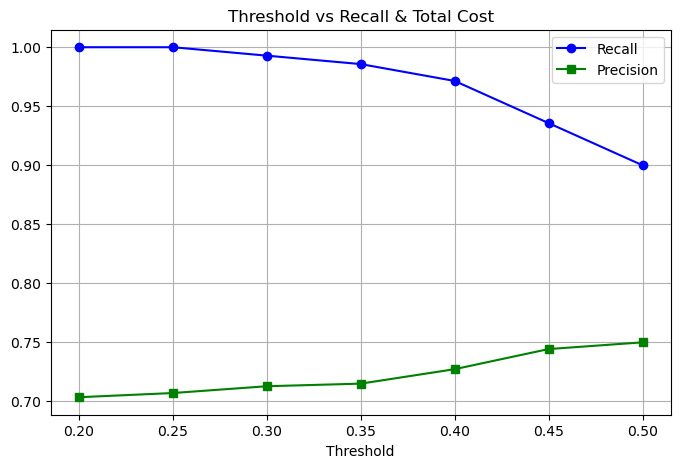

In [39]:
plt.figure(figsize=(8, 5))
plt.plot(df_thresh["threshold"], df_thresh["recall"], color='blue', label='Recall', marker='o')
# plt.plot(df_thresh["threshold"], df_thresh["total_cost"], color='red', label='Total Cost', marker='s')
plt.plot(df_thresh["threshold"], df_thresh["precision"], color='green', label='Precision', marker='s')
plt.xlabel("Threshold")
plt.title("Threshold vs Recall & Total Cost")
plt.legend()
plt.grid(True)
plt.show()